In [1]:
import drjit as dr
import mitsuba as mi
mi.set_variant('cuda_ad_rgb', 'llvm_ad_rgb')

In [2]:
import matplotlib.pyplot as plt
def plot_list(images, title=None):
    fig, axs = plt.subplots(1, len(images), figsize=(18, 3))
    for i in range(len(images)):
        axs[i].imshow(mi.util.convert_to_bitmap(images[i]))
        axs[i].axis('off')
    if title is not None:
        plt.suptitle(title)

In [3]:
# Rendering resolution
render_res = 256

# Number of stages
num_stages = 4

# Number of training iteration per stage
num_iterations_per_stage = 15

# learning rate
learning_rate = 0.2

# Initial grid resolution
grid_init_res = 16

# Spherical harmonic degree to be use for view-dependent appearance modeling
sh_degree = 2

# Enable ReLU in integrator
use_relu = True

# Number of sensors
sensor_count = 7

In [4]:
sensors = []

for i in range(sensor_count):
    angle = 360.0 / sensor_count * i
    sensors.append(mi.load_dict({
        'type': 'perspective',
        'fov': 45,
        'to_world': mi.ScalarTransform4f.translate([0.5, 0.5, 0.5]) \
                                        .rotate([0, 1, 0], angle)   \
                                        .look_at(target=[0, 0, 0],
                                                 origin=[0, 0, 1.3],
                                                 up=[0, 1, 0]),
        'film': {
            'type': 'hdrfilm',
            'width': render_res,
            'height': render_res,
            'filter': {'type': 'box'},
            'pixel_format': 'rgba'
        }
    }))

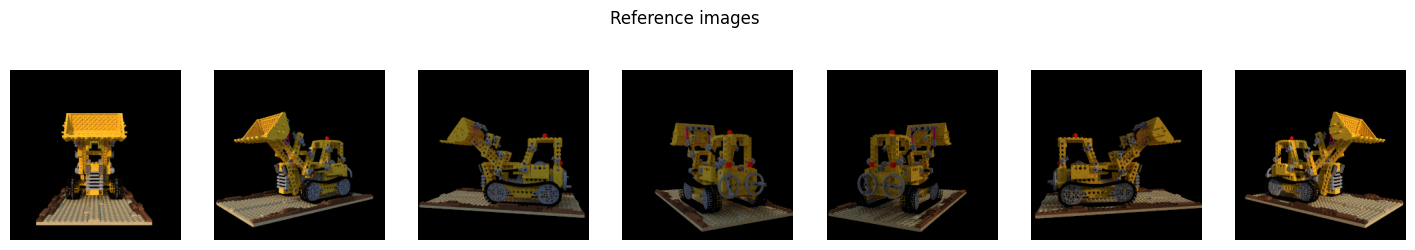

In [5]:
scene_ref = mi.load_file('../scenes/lego/scene.xml')
ref_images = [mi.render(scene_ref, sensor=sensors[i], spp=64) for i in range(sensor_count)]
plot_list(ref_images, 'Reference images')

In [6]:
class RadianceFieldPRB(mi.ad.common.RBIntegrator):
    def __init__(self, props=mi.Properties()):
        super().__init__(props)
        self.bbox = mi.ScalarBoundingBox3f([0.0, 0.0, 0.0], [1.0, 1.0, 1.0])
        self.use_relu = use_relu
        self.grid_res = grid_init_res
        # Initialize the 3D texture for the density and SH coefficients
        res = self.grid_res
        self.sigmat = mi.Texture3f(dr.full(mi.TensorXf, 0.01, shape=(res, res, res, 1)))
        self.sh_coeffs = mi.Texture3f(dr.full(mi.TensorXf, 0.1, shape=(res, res, res, 3 * (sh_degree + 1) ** 2)))

    def eval_emission(self, pos, direction):
        spec = mi.Spectrum(0)
        sh_dir_coef = dr.sh_eval(direction, sh_degree)
        sh_coeffs = self.sh_coeffs.eval(pos)
        for i, sh in enumerate(sh_dir_coef):
            spec += sh * mi.Spectrum(sh_coeffs[3 * i:3 * (i + 1)])
        return dr.clip(spec, 0.0, 1.0)

    def sample(self, mode, scene, sampler,
               ray, δL, state_in, active, **kwargs):
        primal = mode == dr.ADMode.Primal

        ray = mi.Ray3f(ray)
        hit, mint, maxt = self.bbox.ray_intersect(ray)

        active = mi.Bool(active)
        active &= hit  # ignore rays that miss the bbox
        if not primal:  # if the gradient is zero, stop early
            active &= dr.any(dr.neq(δL, 0))

        step_size = mi.Float(1.0 / self.grid_res)
        t = mi.Float(mint) + sampler.next_1d(active) * step_size
        L = mi.Spectrum(0.0 if primal else state_in)
        δL = mi.Spectrum(δL if δL is not None else 0)
        β = mi.Spectrum(1.0) # throughput

        loop = mi.Loop(name=f"PRB ({mode.name})",
                       state=lambda: (sampler, ray, L, t, δL, β, active))
        while loop(active):
            p = ray(t)
            with dr.resume_grad(when=not primal):
                sigmat = self.sigmat.eval(p)[0]
                if self.use_relu:
                    sigmat = dr.maximum(sigmat, 0.0)
                tr = dr.exp(-sigmat * step_size)
                # Evaluate the directionally varying emission (weighted by transmittance)
                Le = β * (1.0 - tr) * self.eval_emission(p, ray.d)
                if not primal:
                    dr.backward_from(δL * (L * tr / dr.detach(tr) + Le))
            β *= tr
            L = L + Le if primal else L - Le
            t += step_size
            active &= (t < maxt) & dr.any(dr.neq(β, 0.0))

        return L if primal else δL, mi.Bool(True), L

    def traverse(self, callback):
        callback.put_parameter("sigmat", self.sigmat.tensor(), mi.ParamFlags.Differentiable)
        callback.put_parameter('sh_coeffs', self.sh_coeffs.tensor(), mi.ParamFlags.Differentiable)

    def parameters_changed(self, keys):
        self.sigmat.set_tensor(self.sigmat.tensor())
        self.sh_coeffs.set_tensor(self.sh_coeffs.tensor())
        self.grid_res = self.sigmat.shape[0]

mi.register_integrator("rf_prb", lambda props: RadianceFieldPRB(props))

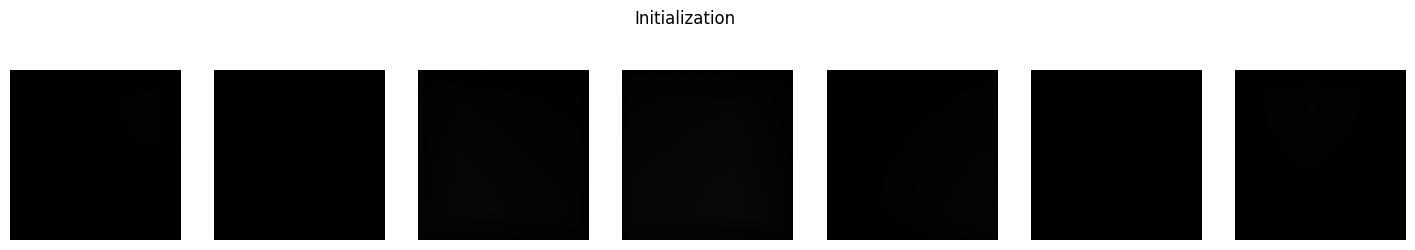

In [7]:
scene = mi.load_dict({
    'type': 'scene',
    'integrator': {
        'type': 'rf_prb'
    },
    'emitter': {
        'type': 'constant'
    }
})
integrator = scene.integrator()

# Render initial state
init_images = [mi.render(scene, sensor=sensors[i], spp=128) for i in range(sensor_count)]
plot_list(init_images, 'Initialization')

In [8]:
params = mi.traverse(integrator)
opt = mi.ad.Adam(lr=learning_rate, params={'sigmat': params['sigmat'], 'sh_coeffs': params['sh_coeffs']})
params.update(opt);

In [9]:
losses = []
intermediate_images = []

# stage
for stage in range(num_stages):
    print(
        f"Stage {stage+1:02d}, feature voxel grids resolution -> {opt['sigmat'].shape[0]}")

    # number of iterations per stage
    for it in range(num_iterations_per_stage):
        total_loss = 0.0
        images = []

        # number of sensors
        for sensor_idx in range(sensor_count):
            img = mi.render(
                scene, params, sensor=sensors[sensor_idx], spp=1, seed=it)
            loss = dr.mean(dr.abs(img - ref_images[sensor_idx]))
            dr.backward(loss)
            total_loss += loss[0]

            # Store images at the end of every stage
            if it == num_iterations_per_stage - 1:
                dr.eval(img)
                images.append(img)

        losses.append(total_loss)
        opt.step()

        if not integrator.use_relu:
            opt['sigmat'] = dr.maximum(opt['sigmat'], 0.0)

        params.update(opt)
        print(f"  --> iteration {it+1:02d}: error={total_loss:6f}", end='\r')

    intermediate_images.append(images)

    # Upsample the 3D textures at every stage
    if stage < num_stages - 1:
        new_res = 2 * opt['sigmat'].shape[0]
        new_shape = [new_res, new_res, new_res]
        opt['sigmat'] = dr.upsample(opt['sigmat'],   new_shape)
        opt['sh_coeffs'] = dr.upsample(opt['sh_coeffs'], new_shape)
        params.update(opt)

print('')
print('Done')


Stage 01, feature voxel grids resolution -> 16
Stage 02, feature voxel grids resolution -> 32
Stage 03, feature voxel grids resolution -> 64
Stage 04, feature voxel grids resolution -> 128
jit_flush_malloc_cache(): Dr.Jit exhausted the available memory and had to flush its allocation cache to free up additional memory. This is an expensive operation and will have a negative effect on performance. You may want to change your computation so that it uses less memory. This warning will only be displayed once.
  --> iteration 15: error=1.325148
Done


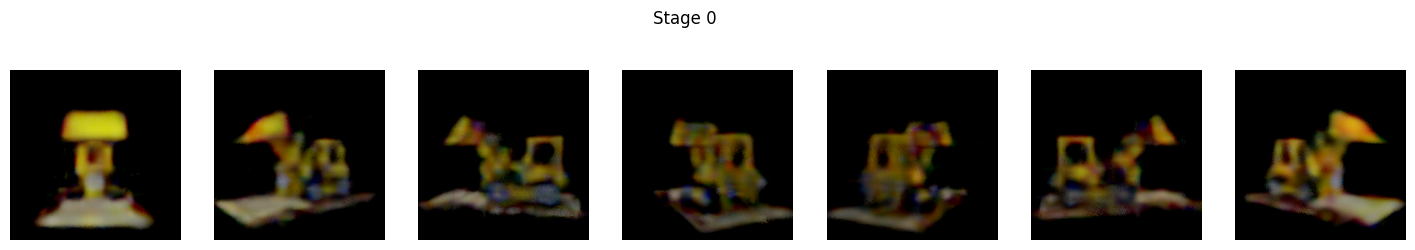

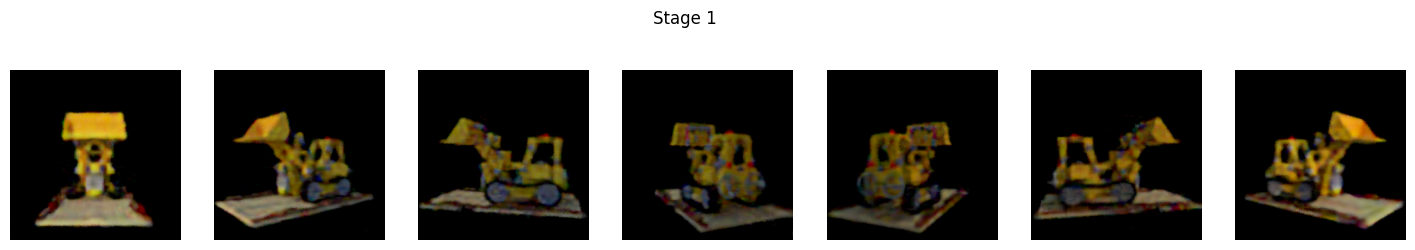

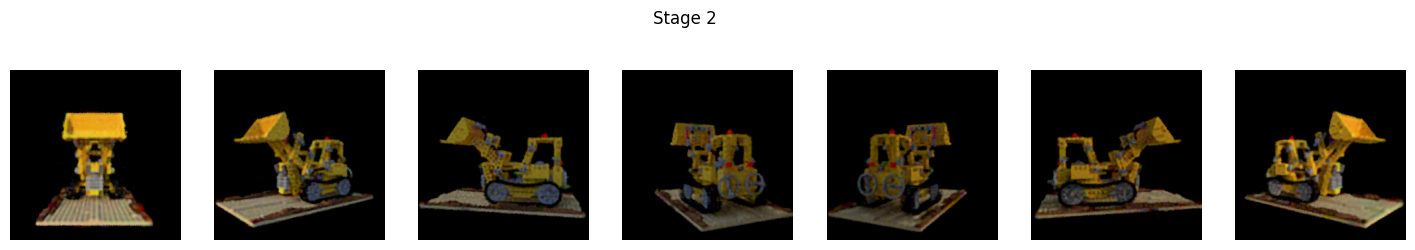

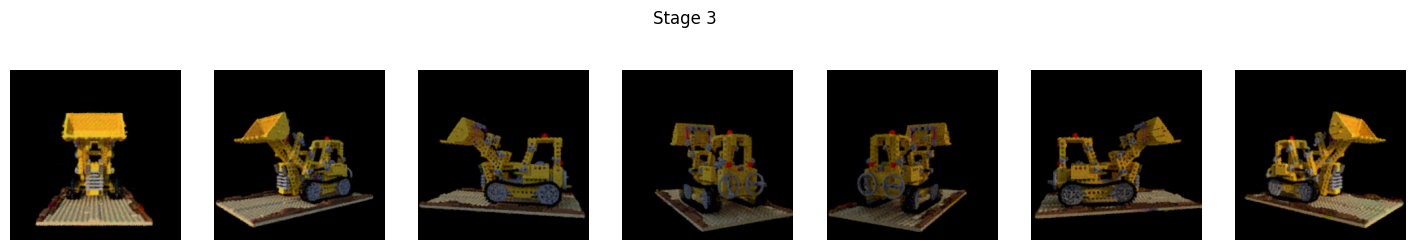

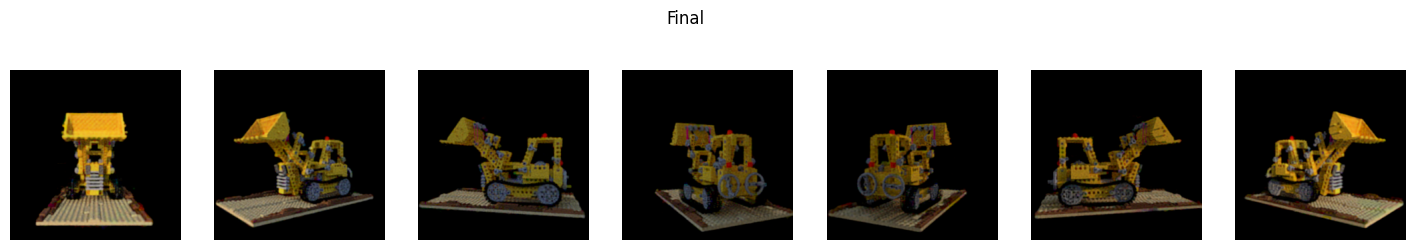

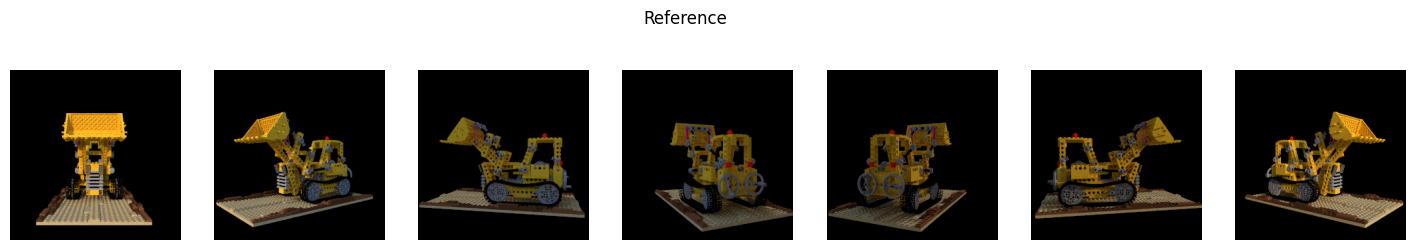

In [10]:
final_images = [mi.render(scene, sensor=sensors[i], spp=128) for i in range(sensor_count)]
for stage, inter in enumerate(intermediate_images):
    plot_list(inter, f'Stage {stage}')
plot_list(final_images, 'Final')
plot_list(ref_images, 'Reference')

Text(0, 0.5, 'Loss')

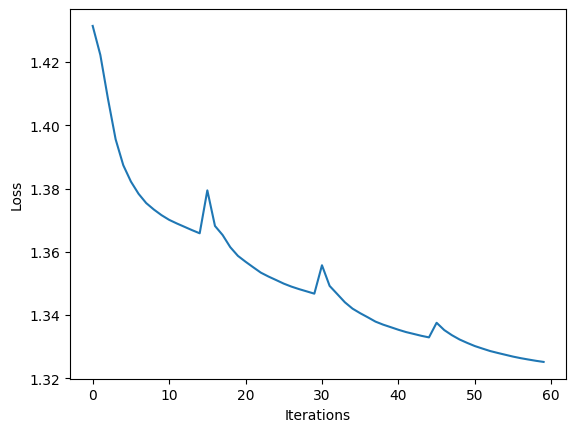

In [11]:
plt.plot(losses)
plt.xlabel('Iterations')
plt.ylabel('Loss')

In [33]:
testSensor = mi.load_dict({
        'type': 'perspective',
        'fov': 45,
        'to_world': mi.ScalarTransform4f.translate([0.5, 0.5, 0.5]) \
                                        .rotate([0, 1, 0], 0)   \
                                        .look_at(target=[0, 0, 0],
                                                 origin=[0, 0, 1.3],
                                                 up=[0, 1, 0]),
        'film': {
            'type': 'hdrfilm',
            'width': 1024,
            'height': 1024,
            'filter': {'type': 'box'},
            'pixel_format': 'rgba'
        }
    })

In [39]:
test = mi.render(scene, sensor=testSensor, spp=1024)
mi.util.convert_to_bitmap(test)

Bitmap[
  pixel_format = rgb,
  component_format = uint8,
  size = [1024, 1024],
  srgb_gamma = 1,
  struct = Struct<3>[
    uint8 R; // @0, normalized, gamma, premultiplied alpha
    uint8 G; // @1, normalized, gamma, premultiplied alpha
    uint8 B; // @2, normalized, gamma, premultiplied alpha
  ],
  data = [ 3 MiB of image data ]
]

In [40]:
mi.util.write_bitmap("test_relu.png", test)

In [54]:
ref_images[0][3]

TensorXf(shape=(256, 4))